#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import gc
from tqdm import tqdm, tqdm_notebook

##### Load data

In [2]:
train = pd.read_csv('Data/Train/Train.csv')
sub = pd.read_csv('Data/sample_submmission.csv')
test = pd.read_csv('Data/test_l0Auv8Q.csv')
fh = pd.read_csv('Data/Train/First_Health_Camp_Attended.csv')
sh = pd.read_csv('Data/Train/Second_Health_Camp_Attended.csv')
th = pd.read_csv('Data/Train/Third_Health_Camp_Attended.csv')
pp = pd.read_csv('Data/Train/Patient_Profile.csv')
hc = pd.read_csv('Data/Train/Health_Camp_Detail.csv')

In [3]:
train.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7


In [4]:
test.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0


In [5]:
sub.head(2)

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.5
1,500633,6584,0.5


In [6]:
fh.head(2)

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN


In [7]:
sh.head(2)

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700


In [8]:
th.head(2)

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1


In [9]:
hc.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2


In [10]:
pp.head(2)

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry


In [11]:
pp['online_Activity_Score']=pp['Online_Follower']+pp['LinkedIn_Shared']+pp['Twitter_Shared']+pp['Facebook_Shared']
del pp['Online_Follower']
del pp['LinkedIn_Shared']
del pp['Twitter_Shared']
del pp['Facebook_Shared']

In [12]:
train.shape,test.shape,sub.shape,fh.shape,sh.shape,th.shape,pp.shape,hc.shape

((75278, 8),
 (35249, 8),
 (35249, 3),
 (6218, 5),
 (7819, 3),
 (6515, 4),
 (37633, 8),
 (65, 6))

#### Preprocessing Data

#### Preprocessing and feature engineering patient profile

In [13]:
pp[['Income', 'Education_Score', 'Age']] = pp[['Income', 'Education_Score', 'Age']].apply(lambda x: x.str.replace('None', 'NaN').astype('float'))

In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in ['City_Type','Employer_Category']:
    pp[col]=  pp[col].astype('str')
    pp[col]= le.fit_transform(pp[col]) 

In [15]:
pp['first_interaction_year'] = pd.to_datetime(pp['First_Interaction']).dt.year
pp['first_interaction_month'] = pd.to_datetime(pp['First_Interaction']).dt.month
pp['first_interaction_day'] = pd.to_datetime(pp['First_Interaction']).dt.day

In [16]:
pp.head(2)

,Patient_ID,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,online_Activity_Score,first_interaction_year,first_interaction_month,first_interaction_day
0,516956,1.0,90.0,39.0,18-Jun-03,9,10,0,2003,6,18
1,507733,1.0,NaN,40.0,20-Jul-03,7,10,0,2003,7,20


#### Preprocessing and feature engineering Train

In [17]:
train['registration_year'] = pd.to_datetime(train['Registration_Date']).dt.year
train['registration_month'] = pd.to_datetime(train['Registration_Date']).dt.month
train['registration_day'] = pd.to_datetime(train['Registration_Date']).dt.day

In [18]:
train['Registration_Date']=pd.to_datetime(train['Registration_Date'])
train.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)

In [20]:
train['days_since_last_registration'] = train.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
train['days_since_next_registration'] = train.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')       
train.reset_index(drop=True,inplace=True)                                                                                                      

In [21]:
train['Unique_Health_Camp_per_patient']=train.groupby(['Patient_ID'])['Health_Camp_ID'].transform('nunique')
train['Unique_Patient_per_HealthCamp']=train.groupby(['Health_Camp_ID'])['Patient_ID'].transform('nunique')
train['Unique_year_per_patient']=train.groupby(['Patient_ID'])['registration_year'].transform('nunique')
train['Unique_months_per_patient']=train.groupby(['Patient_ID'])['registration_month'].transform('nunique')
train['Unique_day_per_patient']=train.groupby(['Patient_ID'])['registration_day'].transform('nunique')

In [22]:
train.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,registration_year,registration_month,registration_day,days_since_last_registration,days_since_next_registration,Unique_Health_Camp_per_patient,Unique_Patient_per_HealthCamp,Unique_year_per_patient,Unique_months_per_patient,Unique_day_per_patient
0,485679,6578,2005-08-22,0,0,0,0,0,2005.0,8.0,22.0,NaN,9.0,2,2837,1.0,1.0,2.0
1,485679,6555,2005-08-31,0,0,0,0,0,2005.0,8.0,31.0,9.0,NaN,2,1738,1.0,1.0,2.0


#### Preprocessing and feature engineering Test

In [23]:
test['registration_year'] = pd.to_datetime(test['Registration_Date']).dt.year
test['registration_month'] = pd.to_datetime(test['Registration_Date']).dt.month
test['registration_day'] = pd.to_datetime(test['Registration_Date']).dt.day

In [24]:
test['Registration_Date']=pd.to_datetime(test['Registration_Date'])
test.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)

In [25]:
test['days_since_last_registration'] = test.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
test['days_since_next_registration'] = test.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')
test.reset_index(drop=True,inplace=True)

In [26]:
test['Unique_Health_Camp_per_patient']=test.groupby(['Patient_ID'])['Health_Camp_ID'].transform('nunique')
test['Unique_Patient_per_HealthCamp']=test.groupby(['Health_Camp_ID'])['Patient_ID'].transform('nunique')
test['Unique_year_per_patient']=test.groupby(['Patient_ID'])['registration_year'].transform('nunique')
test['Unique_months_per_patient']=test.groupby(['Patient_ID'])['registration_month'].transform('nunique')
test['Unique_day_per_patient']=test.groupby(['Patient_ID'])['registration_day'].transform('nunique')

In [27]:
test.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,registration_year,registration_month,registration_day,days_since_last_registration,days_since_next_registration,Unique_Health_Camp_per_patient,Unique_Patient_per_HealthCamp,Unique_year_per_patient,Unique_months_per_patient,Unique_day_per_patient
0,485678,6551,2006-11-13,0,0,0,0,0,2006,11,13,NaN,NaN,1,2180,1,1,1
1,485683,6584,2006-05-29,0,0,0,0,0,2006,5,29,NaN,0.0,5,3041,2,2,2


#### find overlap between train and test sets

In [28]:
cols =  ['Patient_ID']
for col in cols:
  print('Total unique'+col  +' values in Train are {}'.format(train[col].nunique()))
  print('Total unique'+col  +' values in Test are {}'.format(test[col].nunique()))
  print('Common'+col +' values are {}'.format(len(list(set(train[col]) & set(test[col])))))
  print('**************************')

Total uniquePatient_ID values in Train are 29828
Total uniquePatient_ID values in Test are 15324
CommonPatient_ID values are 8460
**************************


#### Merging train,test with Patient Profile

In [29]:
train = pd.merge(train, pp, on = 'Patient_ID', how = 'left')
test = pd.merge(test, pp, on = 'Patient_ID', how = 'left')

#### Getting Target

In [30]:
for c in [fh, sh, th, train]:
  c['id'] = c['Patient_ID'].astype('str') + c['Health_Camp_ID'].astype('str')
th = th[th['Number_of_stall_visited'] > 0]

all_patients_in_camp = pd.Series(fh['id'].tolist() + sh['id'].tolist() + th['id'].tolist()).unique()

train['target'] = 0
train.loc[train['id'].isin(all_patients_in_camp), 'target'] = 1

In [31]:
train['target'].value_counts()

0    54744
1    20534
Name: target, dtype: int64

#### Preprocessing and feature engineering first health camp

In [32]:
# groupeddf=fh.groupby('Patient_ID', as_index=False)['Donation'].agg('sum').reset_index(drop=True)
# groupeddf=groupeddf.rename(columns={'Donation':'Donation_Sum'})
# groupeddf=groupeddf[groupeddf['Patient_ID'].isin(test['Patient_ID'])]
# train=pd.merge(train,groupeddf,on=['Patient_ID'],how='left')
# train['Donation_Sum'].fillna(-99,inplace=True)
# test=pd.merge(test,groupeddf,on=['Patient_ID'],how='left')
# test['Donation_Sum'].fillna(-99,inplace=True)

#### preprocessing and feature engineering third health camp

In [33]:
# groupeddf=th.groupby('Patient_ID', as_index=False)['Number_of_stall_visited'].agg('sum').reset_index(drop=True)
# groupeddf=groupeddf.rename(columns={'Number_of_stall_visited':'Total_Stalls_Visited'})
# groupeddf=groupeddf[groupeddf['Patient_ID'].isin(test['Patient_ID'])]
# train=pd.merge(train,groupeddf,on=['Patient_ID'],how='left')
# train['Total_Stalls_Visited'].fillna(-99,inplace=True)
# test=pd.merge(test,groupeddf,on=['Patient_ID'],how='left')
# test['Total_Stalls_Visited'].fillna(-99,inplace=True)

#### Preprocessing and feature engineering health camp details

In [34]:
hc.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2


In [35]:
def timediff(duration):
    duration_in_s = duration.total_seconds()
    days = divmod(duration_in_s, 86400)[0]
    return days

In [36]:
hc['Camp_Duration']=pd.to_datetime(hc['Camp_End_Date'])-pd.to_datetime(hc['Camp_Start_Date'])
hc['Camp_Duration']=hc['Camp_Duration'].apply(timediff)

In [37]:
hc['camp_start_year'] = pd.to_datetime(hc['Camp_Start_Date']).dt.year
hc['camp_start_month'] = pd.to_datetime(hc['Camp_Start_Date']).dt.month
hc['camp_start_day'] = pd.to_datetime(hc['Camp_Start_Date']).dt.day

hc['camp_end_year'] = pd.to_datetime(hc['Camp_End_Date']).dt.year
hc['camp_end_month'] = pd.to_datetime(hc['Camp_End_Date']).dt.month
hc['camp_end_day'] = pd.to_datetime(hc['Camp_End_Date']).dt.day

In [38]:
hc['Category1'] = hc['Category1'].map({'First': 1, 'Second': 2, 'Third': 3})
hc['Category2'] = pd.factorize(hc['Category2'])[0]

In [39]:
hc.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Duration,camp_start_year,camp_start_month,camp_start_day,camp_end_year,camp_end_month,camp_end_day
0,6560,16-Aug-03,20-Aug-03,1,0,2,4.0,2003,8,16,2003,8,20
1,6530,16-Aug-03,28-Oct-03,1,1,2,73.0,2003,8,16,2003,10,28


#### Merging train,test with health camp details

In [40]:
train = pd.merge(train, hc, on = 'Health_Camp_ID', how = 'left')
test = pd.merge(test, hc, on = 'Health_Camp_ID', how = 'left')

#### More Feature Engineering

In [41]:
train['Unique_camp_year_per_patient']=train.groupby(['Patient_ID'])['camp_start_year'].transform('nunique')
train['Unique_camp_months_per_patient']=train.groupby(['Patient_ID'])['camp_start_month'].transform('nunique')
train['Unique_camp_day_per_patient']=train.groupby(['Patient_ID'])['camp_start_day'].transform('nunique')

In [42]:
test['Unique_camp_year_per_patient']=test.groupby(['Patient_ID'])['camp_start_year'].transform('nunique')
test['Unique_camp_months_per_patient']=test.groupby(['Patient_ID'])['camp_start_month'].transform('nunique')
test['Unique_camp_day_per_patient']=test.groupby(['Patient_ID'])['camp_start_day'].transform('nunique')

In [43]:
# groupeddf=train.groupby('Patient_ID', as_index=False)['target'].agg('mean').reset_index(drop=True)
# groupeddf=groupeddf[groupeddf['Patient_ID'].isin(test['Patient_ID'])]
# groupeddf.rename(columns={'target':'meantarget'},inplace=True)
# train=pd.merge(train,groupeddf,on=['Patient_ID'],how='left')
# train['meantarget'].fillna(-99,inplace=True)
# test=pd.merge(test,groupeddf,on=['Patient_ID'],how='left')
# test['meantarget'].fillna(-99,inplace=True)

#### Concat

In [44]:
train['train_or_test']='train'
test['train_or_test']='test'
df=pd.concat([train,test])

#### numeric aggregate feataures grouped by patient_ID

In [45]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').drop(columns={'Patient_ID', 'Health_Camp_ID','target'}).copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [47]:
PID_aggregate = agg_numeric(df, 'Patient_ID', 'agg')
print('PID aggregate shape: ', PID_aggregate.shape)
df=df.merge(PID_aggregate, on ='Patient_ID', how = 'left')

PID aggregate shape:  (36692, 141)


In [49]:
df['Patient_Registered_before_days']=pd.to_datetime(df['Camp_Start_Date'])-pd.to_datetime(df['Registration_Date'])
df['Patient_Registered_before_days']=df['Patient_Registered_before_days'].apply(timediff)

In [50]:
train=df.loc[df.train_or_test.isin(['train'])]
test=df.loc[df.train_or_test.isin(['test'])]
train.drop(columns={'train_or_test'},axis=1,inplace=True)
test.drop(columns={'train_or_test'},axis=1,inplace=True)

#### Creating Time based validation for 5 months ,as same as public and private test period

In [51]:
trn=train[train['Camp_Start_Date'] <'2005-11-01']
val=train[train['Camp_Start_Date'] >'2005-10-30']

In [52]:
train.columns

Index(['Age', 'Camp_Duration', 'Camp_End_Date', 'Camp_Start_Date', 'Category1',
       'Category2', 'Category3', 'City_Type', 'Education_Score',
       'Employer_Category',
       ...
       'agg_Income_mean', 'agg_Income_max', 'agg_Income_min', 'agg_Age_mean',
       'agg_Age_max', 'agg_Age_min', 'agg_Education_Score_mean',
       'agg_Education_Score_max', 'agg_Education_Score_min',
       'Patient_Registered_before_days'],
      dtype='object', length=187)

In [53]:
TARGET_COL = 'target'
features = [c for c in trn.columns if c not in ['Patient_ID', 'Health_Camp_ID','Category3','Registration_Date', 'id','target','Camp_Start_Date','Camp_End_Date','First_Interaction',TARGET_COL]]
len(features)

178

#### validating the data

In [54]:
from lightgbm import LGBMClassifier

In [55]:
clf = LGBMClassifier(n_estimators=550,
                     learning_rate=0.03,
                     min_child_samples=40,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)

clf.fit(trn[features], trn[TARGET_COL], eval_set=[(val[features], val[TARGET_COL])], verbose=50,
        eval_metric = 'auc', early_stopping_rounds = 100)

preds = clf.predict_proba(test[features])[:, 1]

Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.836279	valid_0's binary_logloss: 0.425735
[100]	valid_0's auc: 0.840514	valid_0's binary_logloss: 0.402239
[150]	valid_0's auc: 0.844641	valid_0's binary_logloss: 0.394518
[200]	valid_0's auc: 0.846119	valid_0's binary_logloss: 0.392112
[250]	valid_0's auc: 0.846637	valid_0's binary_logloss: 0.390968
[300]	valid_0's auc: 0.846511	valid_0's binary_logloss: 0.390132
[350]	valid_0's auc: 0.846273	valid_0's binary_logloss: 0.389972
Early stopping, best iteration is:
[276]	valid_0's auc: 0.847016	valid_0's binary_logloss: 0.390273


#### Removing 0 importance feature didnt help

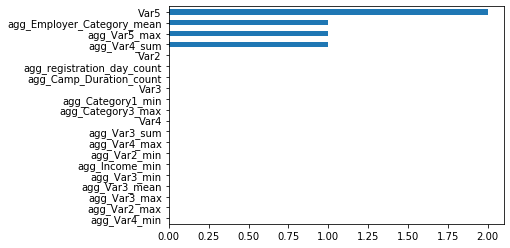

In [56]:
fi = pd.Series(index = features, data = clf.feature_importances_)
fi.sort_values(ascending=False)[-20:][::-1].plot(kind = 'barh')

#### Final Model

#### Blending with different seeds

In [57]:
# preds = 0
# for seed_val, num_rounds in [[1,450], [1997,450], [2020, 450]]:
#     print (seed_val, num_rounds)
#     m=LGBMClassifier(n_estimators=num_rounds,learning_rate=0.03,random_state=seed_val,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
#     m.fit(train[features],train['target'])
#     predict=m.predict_proba(test[features])[:,1]
#     preds += predict
# preds = preds/3.

In [ ]:
preds = 0
for seed_val in [1,3,10,15,20,33,333,1997,2020,2021]:
    print (seed_val)
    m=LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=seed_val,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
    m.fit(train[features],train['target'])
    predict=m.predict_proba(test[features])[:,1]
    preds += predict
preds = preds/10

1
3
10
15
20
33
333


In [ ]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("lgbmblending.csv", index=False)